# Content Metrics Dashboard

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('..')

In [3]:
# project imports
import util.bq_util as bqnb
from code import dashboard_util
from code import plot_funcs
from code.queries import LATEST_MONTH_START, LATEST_MONTH_END, CURR_YEAR, CURR_MONTH, ALL_TIME_START, query_dict
from code.config import COMPARISON_NODES
from code import prep
from code import query_wrappers as qw
try:
    test = bq.tables().list(projectId="khanacademy.org:deductive-jet-827", datasetId="content_metrics").execute()
except:
    bq, gcs = bqnb.get_authed_clients()

Authenticating with BigQuery and GCS...
Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&client_id=124072386181-qqedvnl36ver0khc3pmqbh4bevlh58qd.apps.googleusercontent.com&access_type=offline

Enter verification code: 4/D3yD2JGu7JYzcsYYllhoEJlO9W7JO9Pr6BB59ePZYhY
Authentication successful.


In [16]:
# general imports
import collections
import csv
import copy
import cStringIO
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import ipywidgets
from IPython.display import clear_output, HTML, display, Javascript

In [17]:
cells_visable = True
def toggle_code_cells(btn):
    global cells_visable
    if cells_visable:
        display(Javascript("$('div.input').hide();"))
        btn.description = "Show Code Cells"
    else:
        display(Javascript("$('div.input').show();"))
        btn.description = "Hide Code Cells"
    cells_visable = not cells_visable
    
    
toggle_code = ipywidgets.Button(description="Hide Code Cells", button_style="warning", width="800px")
toggle_code.on_click(toggle_code_cells)

toggle_refresh = ipywidgets.ToggleButtons(
    options=['Reuse Data', 'Refresh Data'],
)
display(toggle_code)

In [18]:
display(toggle_refresh)

In [19]:
# fetch data
if toggle_refresh.value == "Refresh Data":
    DATA, USAGE_DFS = qw.fetch_all_dashboard_data(bq)
    dashboard_util.save_to_gcs(gcs, DATA, USAGE_DFS)
else:
    DATA, USAGE_DFS = dashboard_util.load_from_gcs(gcs)

In [20]:
# query viewer callback
def print_query_callback(btn):
    print query_dict[query_chooser.value]
query_chooser = ipywidgets.Dropdown(padding=4, options=sorted(query_dict.keys()), width="270px")
query_chooser.on_trait_change(clear_output)
title = ipywidgets.HTML(value='<h3> Query Viewer </h3> ')
view_button = ipywidgets.Button(description='View Query', width="300px", button_style="warning")
view_button.on_click(print_query_callback)
query_container = ipywidgets.VBox([title, query_chooser, view_button])

In [21]:
# Setup Dashboard Widget for Content production
PRODUCTION_PLOT_STATE = {"content_type": "all", "main_type": "Total Content", "comparisons":[]}
PRODUCTION_STATE_BOX = ipywidgets.HTML(value='')

def plot_spec(main_type=None, content_type=None, comparisons=None):
    if main_type == "Total Content":
        kind = "Total"
        input_df = DATA['content_total_timecourse_df']
    else:
        kind = "New"
        input_df = DATA['content_added_timecourse_df']
    clear_output()
    plot_funcs.construct_plotdf(input_df, comparisons, content_type, kind)
    
def content_type_callback(btn):
    PRODUCTION_PLOT_STATE["content_type"]=btn.description
    PRODUCTION_PLOT_STATE["comparisons"] = prod_selector.value
    plot_spec(**PRODUCTION_PLOT_STATE)
    display_state(PRODUCTION_STATE_BOX, PRODUCTION_PLOT_STATE)

def plot_type_callback(btn):
    PRODUCTION_PLOT_STATE["main_type"]=btn.description
    PRODUCTION_PLOT_STATE["comparisons"] = prod_selector.value
    plot_spec(**PRODUCTION_PLOT_STATE)
    display_state(PRODUCTION_STATE_BOX, PRODUCTION_PLOT_STATE)

def display_state(state, current_global_state):
    main_type = current_global_state["main_type"]
    content_type = current_global_state["content_type"]
    comparisons = ", ".join(current_global_state["comparisons"])
    state.value = '<h3>%s</h3> <h4>content type: %s</h4>  <h4>comparisons: %s</h4>' %(main_type, content_type, comparisons)

prod_container, prod_selector = dashboard_util.create_production_widgets(content_type_callback, plot_type_callback)

In [28]:
# Setup dashboard widget for content usage
USAGE_PLOT_STATE = {"content_type": "all", "main_type": "Learners", "comparisons": ['Physics', 'Biology', 'Chemistry']}
USAGE_STATE_BOX = ipywidgets.HTML(value='')

def give_plot_options(main_type=None, content_type=None, comparisons=None):
    if content_type == "video":
        yt_button.visible=True

def content_type_usage_callback(btn):
    yt_button.visible=False
    set_plot_state(comparisons=usage_selector.value, content_type=btn.description[:-1] if btn.description.endswith("s") else btn.description)
    display_state(USAGE_STATE_BOX, USAGE_PLOT_STATE)
    give_plot_options(**USAGE_PLOT_STATE)
    render()

def usage_type_callback(btn):
    set_plot_state(comparisons=usage_selector.value, main_type=btn.description)
    display_state(USAGE_STATE_BOX, USAGE_PLOT_STATE)
    give_plot_options(**USAGE_PLOT_STATE)
    render()
    
def set_plot_state(comparisons=None, main_type=None, content_type=None):
    if comparisons:
        USAGE_PLOT_STATE["comparisons"] = comparisons
    if main_type:
        USAGE_PLOT_STATE["main_type"] = main_type
    if content_type:
        USAGE_PLOT_STATE["content_type"]= content_type

# views
def render():
    df = prep.construct_df(USAGE_DFS, USAGE_PLOT_STATE)
    clear_output()
    f,axes = plt.subplots(2,1,figsize=[12,8])
    if USAGE_PLOT_STATE["main_type"] == "Learners":
        column = "num_learners"
    elif USAGE_PLOT_STATE["main_type"] == "Learning Time":
        column = "TLT"
    elif USAGE_PLOT_STATE["main_type"] == "Learning Actions":
        column = "num_content_learned"
    else:
        column = "num_learners"
    yoy_growth = prep.calc_yoy_growth(df, column)
    plot_funcs.plot_timecourse(df, column, column, column, ax=axes[0], kind="area")
    if len(yoy_growth)>0:
        plot_funcs.plot_yoy_growth(yoy_growth, column, ax=axes[1])
    plt.tight_layout()
    
## YT data
def yt_callback(btn):
    plot_funcs.make_yt_plot(DATA['yt_logs'])
def completion_callback(btn):
    set_plot_state(comparisons=usage_selector.value)
    plot_funcs.plot_completion(USAGE_DFS, USAGE_PLOT_STATE)
def returning_callback(btn):
    clear_output()
    set_plot_state(comparisons=usage_selector.value, main_type="Churn Stats")
    plotdf, churndf = prep.analyze_new_learners(DATA['new_learner_df'], USAGE_DFS, USAGE_PLOT_STATE["content_type"], USAGE_PLOT_STATE["comparisons"])
    plot_funcs.plot_new_learner_props(plotdf)
    display_state(USAGE_STATE_BOX, USAGE_PLOT_STATE)
    display(churndf)
def request_callback(btn):
    clear_output()
    set_plot_state(comparisons=usage_selector.value, main_type="Visitor/Session Stats")
    display_state(USAGE_STATE_BOX, USAGE_PLOT_STATE)
    plot_funcs.plot_visitors(DATA['request_logs_breakdown'], USAGE_PLOT_STATE["comparisons"], USAGE_PLOT_STATE["content_type"])

comp_button = ipywidgets.Button(description="Plot Completion Rates", button_style="warning", width="200px", margin="3px")
comp_button.on_click(completion_callback)
returning_button = ipywidgets.Button(description="Plot Return/Churn Stats", button_style="warning", width="200px", margin="3px")
returning_button.on_click(returning_callback)
request_button = ipywidgets.Button(description="Plot Visitors & Sessions", button_style="warning", width="200px", margin="3px")
request_button.on_click(request_callback)
yt_button = ipywidgets.Button(description="Plot YouTube vs KA usage", button_style="warning", width="200px", visible=False, margin="3px")
yt_button.on_click(yt_callback)
usage_container, usage_selector = dashboard_util.create_usage_widgets(content_type_usage_callback, usage_type_callback, extra_buttons=[comp_button, returning_button, request_button, yt_button])

In [29]:
#set up export of final reports
def construct_export_df(export_name):
    if export_name == "content_production_history":
        df = prep.create_production_history(DATA['content_total_timecourse_df'],
                                            DATA['content_added_timecourse_df'])
    elif export_name == "content_production_snapshot":
        df = prep.create_production_snapshot(DATA['total_content_available'],
                                             DATA['content_added_this_month'])
    elif export_name == "content_usage_history":
        df = prep.create_usage_history(USAGE_DFS)
    elif export_name == "content_usage_snapshot":
        df = prep.create_usage_snapshot(USAGE_DFS, 
                                        DATA['request_logs_breakdown'], 
                                        DATA['yt_logs'], 
                                        DATA['new_learner_df'])
    return df
def export_handler(widget):
    filename = dashboard_util.exporter_names.value
    df = construct_export_df(dashboard_util.exporter_names.value)
    download_link.value = dashboard_util.export(filename, df)
    download_link.visible = True
    return df
download_link = ipywidgets.HTML(visible=False)
dashboard_util.export_button.on_click(export_handler)
dashboard_util.exporter_names.on_trait_change(lambda x: setattr(download_link, "visible", False))

# Content Metrics Dashboard
## ............................................................................................................................................................

In [30]:
display(prod_container)
display(PRODUCTION_STATE_BOX)

## ............................................................................................................................................................

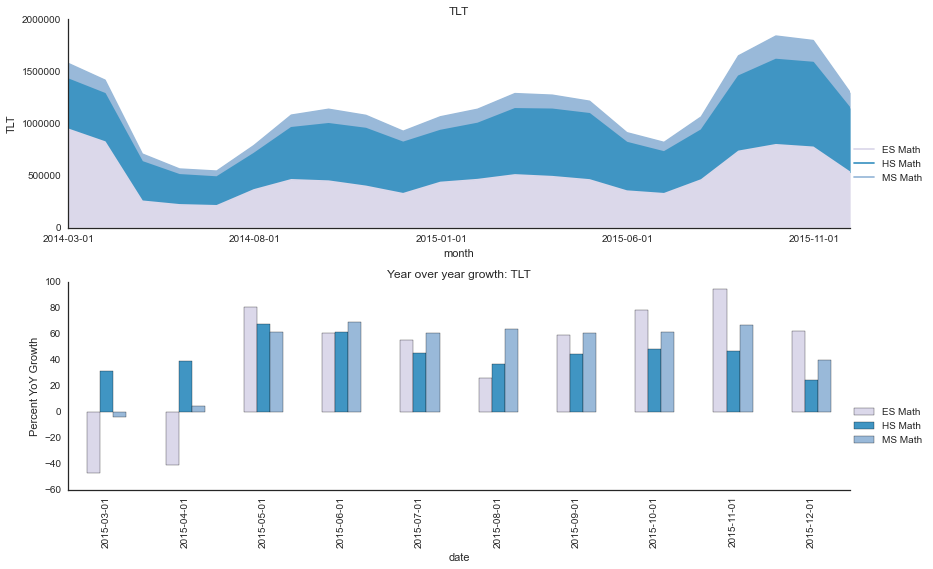

In [31]:
display(usage_container)
display(USAGE_STATE_BOX)

## ............................................................................................................................................................

In [33]:
display(dashboard_util.exporter_names)
display(dashboard_util.export_button)
download_link.visible=False
display(download_link)

## ............................................................................................................................................................

In [27]:
display(query_container)

# NOTES

Some weirdnesses to look into/be aware of:
- missing college admissions data (I know why, will fix)
- need to fix the new vs returning user stats
- strange numbers for pixar -- possiblly taking content that is actually math? need to figure out how to handle content that is in multiple domains (main culprit is test-prep which we exclude, but there may be a growing number of other cases)
- query to get visitors/sessions with all Core Academic fails with resources exceeded
- query to get new vs. returning for Core Academic fails 


TODOS
- make fix for college admissions
- get num_completers and the video lengths/avg completion percentages
- figure out what is up with pixar